# Problem description
We want to check the similarity between distinct related groups of nouns in the animals semantic field (as an example). For this, we have divided animal words in different categories, based on distinct "subfields", such as 'farm' animals or animals commonly considered as pets. We have also created categories based on social/human biases, such as animals commonly associated with food (chicken, shrimp..) or with unrelated items (mouse as in computer mouse).

We have used the object prototypes from openAI's CLIP dataset for this task due to the higher availability of animal-related nouns, although many common ones such as fox or even aquatic animals (dolphin, shark, whale...) are missing.

Our hypothesis is that, while the text embeddings encode their own biases and groupings between semantically related concepts, their combination with image-based embeddings will have amplified this behavior, as the surrounding contexts of the objects in the images may encode biases not mentioned as frequently in the text (e.g., a cow is implicitly assumed to appear in farms due to our own human bias and is not always mentioned in the text, while their pictures will directly encode that).

During testing, we will check the similarities between words assigned to each category, via qualitative analysis (intra-group and inter-group similarity scores), visualizations (2d and 3d plottings) and quantitative analysis (KMeans and K-nearest neighbors clustering vs. our categories)

# Imports

In [ ]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
try:
  from adjustText import adjust_text
except:
  !pip install adjustText
  from adjustText import adjust_text
import random
from scipy import spatial

# Fuzzy search box for the object prototype keys
from ipywidgets import interact, widgets
!pip install fuzzywuzzy
from fuzzywuzzy import process

# 3D visualization
import plotly.graph_objects as go

# Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors

# Save plots as a video
!pip install kaleido
import imageio.v2 as imageio

# Auxiliary functions

In [2]:
def reduce_dim(space, list_of_words, dims):
  X = np.array([space[key] for key in list_of_words])
  pca = PCA(n_components=dims)

  return dict(zip(list_of_words, pca.fit_transform(X)))

In [3]:
# Visualization function for 2 dimensions, from the original multimodality colab
# notebook
def visualize(list_of_words, space, domain_dict):
  # Create a color map
  domains = set(domain_dict.values())
  colors = ['red', 'blue', 'green', 'black', 'yellow', 'pink', 'purple']
  color_map = {domain: color for domain, color in zip(domains, colors)}

  # Initialize plot
  fig, ax = plt.subplots(figsize=(12, 7))

  texts = []
  legend_labels = {}

  for word in list_of_words:
    x = space[word][0]
    y = space[word][1]

    # Get the domain and corresponding color for each word
    domain = domain_dict[word]
    color = color_map[domain]

    # Plot the word's position as a dot, colored by its domain
    ax.scatter(x, y, color=color)

    # Annotate the dot with the word
    texts.append(ax.annotate(word, xy=(x, y), fontsize=13))

    # Add to legend labels (if not already added)
    if domain not in legend_labels:
        legend_labels[domain] = color

  # Adjust text to avoid overlapping
  adjust_text(texts)

  # Add legend
  handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in legend_labels.values()]
  ax.legend(handles, legend_labels.keys(), title='Domains')

  plt.show()

In [4]:
# Visualization function for 3 dimensions, allowing for interaction via plotly
def visualize_3d_interactive(list_of_words, space, domain_dict, plot_name):
    domains = set(domain_dict.values())
    colors = ['red', 'blue', 'green', 'black', 'yellow', 'pink', 'purple']
    color_map = {domain: color for domain, color in zip(domains, colors)}

    # Instead of a matplotlib figure, we create a plotly one
    fig = go.Figure()

    # (This is extremely ugly)
    min_x = None
    min_y = None
    min_z = None
    max_x = None
    max_y = None
    max_z = None
    for word in list_of_words:
        x = space[word][0]
        y = space[word][1]
        z = space[word][2]

        if max_x is None or x > max_x:
          max_x = x

        if max_y is None or y > max_y:
          max_y = y

        if max_z is None or z > max_z:
          max_z = z

        if min_x is None or x < min_x:
          min_x = x

        if min_y is None or y < min_y:
          min_y = y

        if min_z is None or z < min_z:
          min_z = z

        domain = domain_dict[word]
        color = color_map[domain]

        # Plot the word's position as a scatter point, colored by its domain
        fig.add_trace(go.Scatter3d(x=[x], y=[y], z=[z], mode='markers+text',
                                   marker=dict(size=5, color=color), text=[word], textposition="top center", showlegend=False))

    # Add the legend
    for domain, color in color_map.items():
        fig.add_trace(go.Scatter3d(x=[None], y=[None], z=[None], mode='markers+text',
                                   marker=dict(size=5, color=color), text=[domain], legendgroup=domain, name=domain))

    # Show a bounding box around the points, with enough space to show all
    # of them (otherwise they collide with the 'walls')
    fig.update_layout(scene=dict(
        xaxis=dict(range=[min_x - 0.5*max_x, max_x + 0.5*max_x]),
        yaxis=dict(range=[min_y - 0.5*max_y, max_y + 0.5*max_y]),
        zaxis=dict(range=[min_z - 0.5*max_z, max_z + 0.5*max_z]),
        aspectmode='cube'
    ))
    fig.show()

In [5]:
def cosine_similarity(v1, v2):
  cos = 1 - spatial.distance.cosine(v1, v2)
  return cos

# Computes the average cosine similarity between the words in the given list
def compute_avg_similarity(words, prototypes):
  if len(words) == 1:
    return 1

  avg_similarity = 0.0

  for i in range(0, len(words)):
    # Calculate the similarity only with words further in the array, this way
    # we avoid calculating duplicate similarities
    for j in range(i + 1, len(words)):
      avg_similarity += cosine_similarity(prototypes[words[i]], prototypes[words[j]])

  return avg_similarity / (len(words) * (len(words) - 1) / 2)

In [6]:
# Calculates the average cosine similarity between words in two lists, so that
# if group_1 = [w_11, w_12] and group_2 = [w_21, w_22], their average cosine
# similarity is:
#   (sim(w_11, w_21) + sim(w_11, w_22) + sim(w_12, w21) + sim(w1_12, w_22)) / 4
def compute_avg_similarity_between_groups(group_1, group_2, prototypes):
  avg_similarity = 0.0

  for word_1 in group_1:
    for word_2 in group_2:
      avg_similarity += cosine_similarity(prototypes[word_1], prototypes[word_2])

  n = len(group_1)+len(group_2)
  return avg_similarity / (n * (n - 1) / 2)

In [7]:
# Returns the n nearest neighbors for the given word (i.e. from highest cosine
# similarity to lowest, excluding the word itself)
def get_nearest_neighbors(word, n, prototypes):
    distances = []

    word_embedding = prototypes[word]

    for k, v in prototypes.items():
        distances.append((k, cosine_similarity(v, word_embedding)))

    sorted_distances = sorted(distances, key=lambda x: x[1], reverse=True)[:n]

    # Remove the distances from the tuples and the first neighbor (which is
    # always going to be the word itself)
    nearest_neighbors = [dist[0] for dist in sorted_distances][1:]

    return nearest_neighbors

In [8]:
# Expands the given words list with the n nearest neighbors of each of its words,
# avoiding duplicates
def expand_with_nearest_neighbors(words, n, prototypes):
  expanded_words = []

  for word in words:
    if word not in expanded_words: # It could have been the nearest neighbor of a previous one
      expanded_words.append(word)
    for nn in get_nearest_neighbors(word, n, prototypes):
      if nn not in expanded_words:
        expanded_words.append(nn)

  return expanded_words

# CLIP dataset preparation

In [9]:
# Note: This may not be available forever
!gdown 1Ref1iybGg5j_daYLZT4ud7q5IYSySTL6

Downloading...
From: https://drive.google.com/uc?id=1Ref1iybGg5j_daYLZT4ud7q5IYSySTL6
To: /content/CLIP_prototypes.pkl
100% 9.32M/9.32M [00:00<00:00, 53.5MB/s]


In [10]:
clip_obj_prototypes = pickle.load(open("CLIP_prototypes.pkl", "rb"))

## We can look up words by performing a fuzzy search on the object prototypes keys

In [11]:
def fuzzy_search(query):
    matches = process.extract(query, clip_obj_prototypes.keys(), limit=5)
    return [match[0] for match in matches]

def search_box(query=""):
    matches = fuzzy_search(query)
    print(matches)

# Create an interactive widget for the search box
interact(search_box, Query=widgets.Text(value='', placeholder='Type here'))

interactive(children=(Text(value='', description='query'), Output()), _dom_classes=('widget-interact',))

<function __main__.search_box(query='')>

## And also by looking at the nearest neighbors of a given word

In [12]:
get_nearest_neighbors('store', 10, clip_obj_prototypes)

['shop',
 'business',
 'storefront',
 'stores',
 'shops',
 'building',
 'kiosk',
 'booth',
 'cafe']

# Perform the analysis

## Prepare the embeddings and categories to analyze

In [13]:
reduced_obj_space_2d = reduce_dim(clip_obj_prototypes, list(clip_obj_prototypes.keys()), 2)
reduced_obj_space_3d = reduce_dim(clip_obj_prototypes, list(clip_obj_prototypes.keys()), 3)

We set up seven different manually-created domains for different animals, based either on how close they are when plotted or on how related they are with each other

In [14]:
prototypes = clip_obj_prototypes

flying_animals = ["owl", "seagull", "goose", "duck", "pigeon", "swan"]

meal_animals = ["turkey", "fish", "chicken", "shrimp"]

farm_animals = ["cow", "bull", "calf", "sheep", "goat", "donkey", "ram", "pig"]

pet_animals = ["kitten", "dog", "cat", "puppy"]

thing_animals = ["mouse", "computer mouse", "mousepad"]

riding_animals = ["horse", "pony"]

# For convenience when plotting the heat map
category_names = ["Flying animal",
                "'Meal' animal",
                "'Farm' animal",
                "'Pet' animal",
                "'Thing' animal",
                "'Riding' animal"]
all_categories = [flying_animals, meal_animals, farm_animals, pet_animals, thing_animals, riding_animals]

# We create a domains dict for the plot functions
domains = {}

for word in flying_animals:
  domains[word] = "Flying animal"

for word in meal_animals:
  domains[word] = "'Meal' animal"

for word in farm_animals:
  domains[word] = "'Farm' animal"

for word in pet_animals:
  domains[word] = "'Pet' animal"

for word in thing_animals:
  domains[word] = "'Thing' animal"

for word in riding_animals:
  domains[word] = "'Riding' animal"

## Qualitative analysis

### Similarity comparison

One easy way to check if the words in each category are similar is to calculate the average cosine similarities between words for each category (intra-group similarities), which are shown below. They should all be, and are, very close to 1.0.

In order to measure the similarities between categories (inter-group similarities), we calculate the average cosine similarities between words of different category pairs. Since there are too many samples, we plot their heatmap. One notable aspect is that these similarities do not go above 0.5, indicating that they are indeed related, but not to an extremely high degree.

Average similarity between words in Flying animal: 0.9581987488553653
Average similarity between words in 'Meal' animal: 0.9764418121600561
Average similarity between words in 'Farm' animal: 0.953876513384782
Average similarity between words in 'Pet' animal: 0.9435654861367465
Average similarity between words in 'Thing' animal: 0.9893956214141929
Average similarity between words in 'Riding' animal: 0.9808462231550581


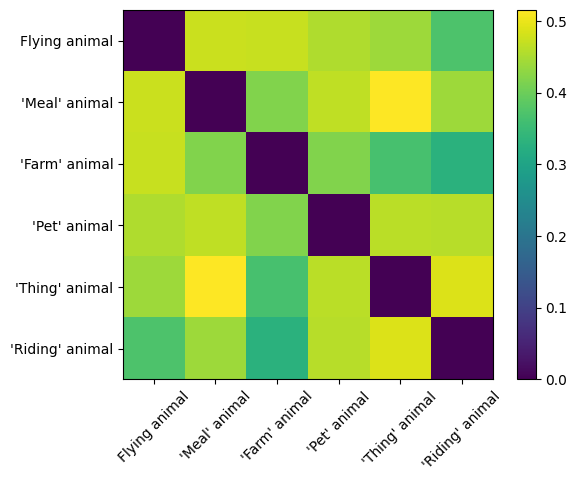

In [15]:
for i, category in enumerate(all_categories):
  print(f"Average similarity between words in {category_names[i]}:", compute_avg_similarity(category, prototypes))

# Instead of doing this, we plot a heatmap
#for i in range(len(all_categories)):
#  for j in range(i+1, len(all_categories)):
#    print(f"Average similarity between categories {category_names[i]} and {category_names[j]}:", compute_avg_similarity_between_groups(all_categories[i], all_categories[j], prototypes))

similarity_matrix = np.zeros((len(all_categories), len(all_categories)))

for i in range(len(all_categories)):
  #similarity_matrix[i, i] = compute_avg_similarity(all_categories[i], prototypes)
  for j in range(i+1, len(all_categories)):
    avg_similarity = compute_avg_similarity_between_groups(all_categories[i], all_categories[j], prototypes)
    similarity_matrix[i, j] = avg_similarity
    similarity_matrix[j, i] = avg_similarity

plt.imshow(similarity_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar()

plt.xticks(np.arange(len(category_names)), category_names, rotation=45)
plt.yticks(np.arange(len(category_names)), category_names)

plt.show()

### Visualization

When plotting them, we can easily see that the categories are easily visible and separable, especially the 'flying', 'meal' and 'thing' animals

One notable outlier is the embedding for 'pig', which seems incorrect. When checking its nearest neighbors, we can see that they are not other animals (shown below). Additionally, 'pony' and 'calf' seem to be located between the 'Pet' and the 'Riding' categories, which is reasonable.

In [16]:
visualize_3d_interactive(flying_animals
                            +meal_animals
                            +farm_animals
                            +pet_animals
                            +thing_animals
                            +riding_animals,
                         reduced_obj_space_3d,
                         domains,
                         "plot_of_our_categories")

The visualization on a 2d plot is a bit harder due to the high number of samples, but we can also distinguish the different categories

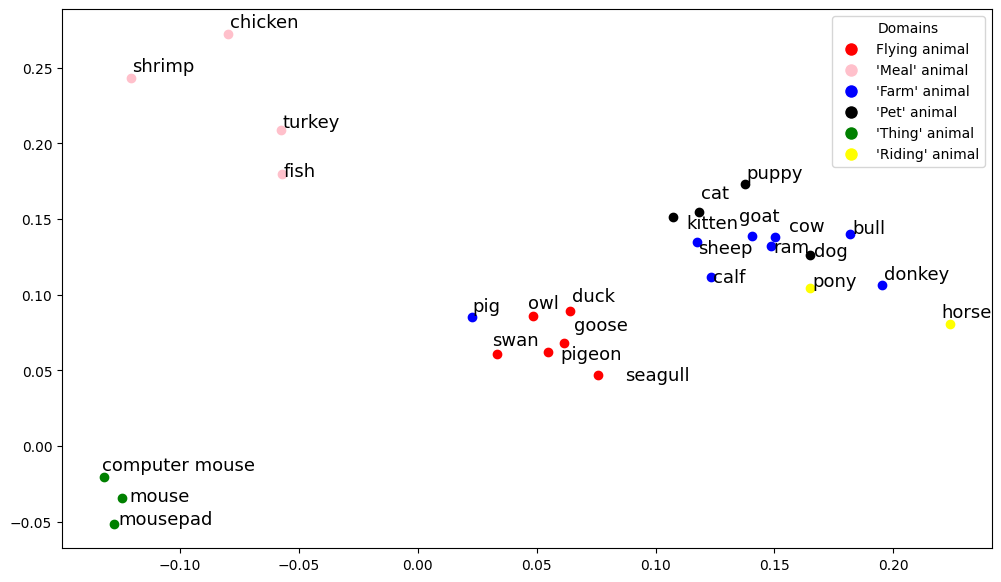

In [17]:
visualize(flying_animals
          +meal_animals
          +farm_animals
          +pet_animals
          +thing_animals
          +riding_animals, reduced_obj_space_2d, domains)

In [18]:
print("Nearest neighbors for the outlier 'pig':")
for nn in get_nearest_neighbors('pig', 10, clip_obj_prototypes):
  print(f"    {nn}")

print()
print("Nearest neighbors for 'pony':")
for nn in get_nearest_neighbors('pony', 10, clip_obj_prototypes):
  print(f"    {nn}")

print()
print("Nearest neighbors for 'calf':")
for nn in get_nearest_neighbors('calf', 10, clip_obj_prototypes):
  print(f"    {nn}")

Nearest neighbors for the outlier 'pig':
    muzzle
    backside
    toy
    heads
    down
    behind
    body
    standing
    snout

Nearest neighbors for 'pony':
    donkey
    horse
    horses
    calf
    animals
    animal
    reigns
    bridle
    halter

Nearest neighbors for 'calf':
    cow
    cows
    cattle
    bull
    goat
    goats
    animal
    animals
    donkey


### Alternative hypothesis

We also looked at other hypotheses, such as gender biases which may be amplified due to the images used to train these models. Unfortunately, the differences in the distances between man and women with regards to a given topic, although noticeable, are not significant enough to be visible in 2d or 3d plots.

In [19]:
print(f"Similarity between soldier and man: {cosine_similarity(clip_obj_prototypes['soldier'], clip_obj_prototypes['man'])}")
print(f"Similarity between soldier and woman: {cosine_similarity(clip_obj_prototypes['soldier'], clip_obj_prototypes['woman'])}")
print()
print(f"Similarity between snowboarder and man: {cosine_similarity(clip_obj_prototypes['snowboarder'], clip_obj_prototypes['man'])}")
print(f"Similarity between snowboarder and woman: {cosine_similarity(clip_obj_prototypes['snowboarder'], clip_obj_prototypes['woman'])}")
print()
print(f"Similarity between blonde and man: {cosine_similarity(clip_obj_prototypes['blonde'], clip_obj_prototypes['man'])}")
print(f"Similarity between blonde and woman: {cosine_similarity(clip_obj_prototypes['blonde'], clip_obj_prototypes['woman'])}")
print()
print(f"Similarity between suit and man: {cosine_similarity(clip_obj_prototypes['suit'], clip_obj_prototypes['man'])}")
print(f"Similarity between suit and woman: {cosine_similarity(clip_obj_prototypes['suit'], clip_obj_prototypes['woman'])}")

Similarity between soldier and man: 0.9449900176411913
Similarity between soldier and woman: 0.9299816136478173

Similarity between snowboarder and man: 0.9402799232816418
Similarity between snowboarder and woman: 0.9086357230645103

Similarity between blonde and man: 0.9416569361564356
Similarity between blonde and woman: 0.9676917342847616

Similarity between suit and man: 0.982112893432586
Similarity between suit and woman: 0.9694929122021052


## Quantitative analysis

Another way to test the similarity between the groups is to try to cluster all samples via KMeans, or to check the nearest neighbors of each one via K-nearest neighbors. This will indicate if the categories we have set up manually are similar to those we would obtain with a clustering algorithm.

### Quantitative analysis with KMeans

We calculate the similarity between its clusters and our categories (which can be seen as a ground truth clustering) via the Jaccard similarity of sets, which returns a value between 0.0 (unrelated) to 1.0 (identical).

We average this similarity across 1000 executions of the KMeans algorithm in order to compensate for its variance.

Due to the categories being visibly separable in the 2d and 3d plots, we expect a score close to 1.0, which is what we obtain (~0.80)

In [20]:
def jaccard_similarity(set1, set2):
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    return len(intersection) / len(union) if len(union) != 0 else 0

names = flying_animals + meal_animals + farm_animals + pet_animals + thing_animals + riding_animals
n_clusters = 6


jaccard_values = []
for i in range(1000):
    embeddings = [prototypes[n] for n in names]
    kmeans = KMeans(n_clusters, n_init='auto').fit(embeddings)

    kmeans_clusters = {} # Categories generated by the KMeans algorithm
    for i, label in enumerate(kmeans.labels_):
        if label not in kmeans_clusters:
            kmeans_clusters[label] = set()

        kmeans_clusters[label].add(names[i])

    # Since we don't know the correspondences between our categories and the
    # clusters, we calculate the Jaccard similarities between all distinct pairs
    # of (category, cluster) and choose the maximum similarity for each of our own
    # categories, calculating the average across them all afterwards
    jaccard_sum = 0
    for category in all_categories:
        max_jaccard = 0
        for _, kmeans_cluster in kmeans_clusters.items():
            jaccard = jaccard_similarity(set(category), kmeans_cluster)
            if jaccard > max_jaccard:
                max_jaccard = jaccard

        jaccard_sum += max_jaccard

    average_jaccard = jaccard_sum / len(all_categories)
    jaccard_values.append(average_jaccard)

average_jaccard = sum(jaccard_values) / len(jaccard_values)
print(average_jaccard)

0.8127615981240957


We can also visualize the results of a KMeans run. One notable difference with our categories is that 'pig' tends to be mistakenly associated with the 'Flying animals' category, while 'pony' and 'dog' vary a lot between different executions.

In [21]:
embeddings = [reduced_obj_space_3d[n] for n in names]
kmeans = KMeans(n_clusters, n_init='auto').fit(embeddings)

# We use build a domains dictionary based on the clusters
kmeans_clusters = {}
for i, label in enumerate(kmeans.labels_):
    kmeans_clusters[names[i]] = f"Cluster  {label}"

visualize_3d_interactive(flying_animals
                            +meal_animals
                            +farm_animals
                            +pet_animals
                            +thing_animals
                            +riding_animals,
                         reduced_obj_space_3d,
                         kmeans_clusters,
                         "plot_of_kmeans_clusters")

### Quantitative with k-nearest neighbors

We can also perform a similar analysis via the K-nearest neighbors algorithm. For this, we also perform 1000 executions and assume that the correct neighbors of each word should be the other words present in its category.

By asking for the closest 5 neighbors of each word, we check how many of them are in its ground truth category and calculate the global precision (total_hits_across_all_words / words*5)

Since the K-nearest neighbors algorithm allows us to use the cosine similarity, we have used this metric instead of the euclidean distance.


In this case, the average precision is also high.

In [22]:
names = flying_animals+meal_animals+farm_animals+pet_animals+thing_animals+riding_animals
embeddings = [prototypes[n] for n in names]

n_neighbors = 5
knn = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine')
knn.fit(embeddings)

avg_precision = 0.0

for _ in range(1000):
  correct_predictions = 0
  total_pairs = 0
  for category in [flying_animals, meal_animals, farm_animals, pet_animals, thing_animals, riding_animals]:
      for i, name in enumerate(category):
          name_idx = names.index(name)

          _distances, indices = knn.kneighbors([embeddings[name_idx]])
          nearest_neighbors = [embeddings[i] for i in indices[0]][1:]
          nearest_neighbors_names = [names[i] for i in indices[0]][1:]

          #print(f"Nearest neighbors of {name}:")
          #for n in nearest_neighbors_names:
          #  print(f"\t{n}")

          # Check how many of the nearest neighbors belong to the same category
          same_category_neighbors = [n for n in nearest_neighbors_names if n in category]
          correct_predictions += len(same_category_neighbors)
          total_pairs += n_neighbors - 1  # Excluding itself

  avg_precision += correct_predictions / total_pairs

print(f"The average precision of the clusters is: {avg_precision / 1000.0}")

The average precision of the clusters is: 0.7685185185185073
